In [1]:
import os, sys, math, time, random, itertools
from typing import Tuple, List, Dict

IMG_ROOT = r"C:\Users\Steven\Desktop\Final Project\Datasets\Dataset_1\Chest X-Ray Images with Pneumothorax Masks\png_images"
TRAIN_CSV = r"C:\Users\Steven\Desktop\Final Project\Datasets\Dataset_1\Chest X-Ray Images with Pneumothorax Masks\stage_1_train_images.csv"
TEST_CSV  = r"C:\Users\Steven\Desktop\Final Project\Datasets\Dataset_1\Chest X-Ray Images with Pneumothorax Masks\stage_1_test_images.csv"

OUT_DIR   = "./ConvNeXt_V2_(Sampler on)output"

EPOCHS    = 100
BATCH     = 32
LR        = 2e-4
SEED      = 42
VAL_RATIO = 0.20       
SAMPLER   = "on"   

print("IMG_ROOT:", IMG_ROOT)
print("TRAIN_CSV:", TRAIN_CSV)
print("TEST_CSV:", TEST_CSV)
print("OUT_DIR:", OUT_DIR)
print("EPOCHS/BATCH/LR:", EPOCHS, BATCH, LR)
print("VAL_RATIO/SAMPLER:", VAL_RATIO, SAMPLER)

IMG_ROOT: C:\Users\Steven\Desktop\Final Project\Datasets\Dataset_1\Chest X-Ray Images with Pneumothorax Masks\png_images
TRAIN_CSV: C:\Users\Steven\Desktop\Final Project\Datasets\Dataset_1\Chest X-Ray Images with Pneumothorax Masks\stage_1_train_images.csv
TEST_CSV: C:\Users\Steven\Desktop\Final Project\Datasets\Dataset_1\Chest X-Ray Images with Pneumothorax Masks\stage_1_test_images.csv
OUT_DIR: ./ConvNeXt_V2_(Sampler on)output
EPOCHS/BATCH/LR: 100 32 0.0002
VAL_RATIO/SAMPLER: 0.2 on


In [2]:
import numpy as np
import pandas as pd
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torchvision import transforms

from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             roc_auc_score, average_precision_score,
                             confusion_matrix, roc_curve, precision_recall_curve)

import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams.update({"figure.dpi": 110})

def set_seed(seed: int = 42):
    random.seed(seed); np.random.seed(seed)
    torch.manual_seed(seed); torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
set_seed(SEED)
print(f"Using device: {device} | AMP: {'on' if device.type=='cuda' else 'off'}")

Using device: cuda | AMP: on


In [3]:
train_df = pd.read_csv(TRAIN_CSV)
test_df  = pd.read_csv(TEST_CSV)

display(train_df.head(8))
display(test_df.head(8))

print("Train shape:", train_df.shape, "Columns:", list(train_df.columns))
print("Test  shape:", test_df.shape, "Columns:", list(test_df.columns))

print("Train label distribution:", train_df["has_pneumo"].value_counts().to_dict())
print("Test  label distribution:", test_df["has_pneumo"].value_counts().to_dict())

,new_filename,ImageId,has_pneumo
0,0_train_0_.png,1.2.276.0.7230010.3.1.4.8323329.5597.151787518...,0
1,1_train_0_.png,1.2.276.0.7230010.3.1.4.8323329.12515.15178752...,0
2,2_train_1_.png,1.2.276.0.7230010.3.1.4.8323329.4904.151787518...,1
3,3_train_1_.png,1.2.276.0.7230010.3.1.4.8323329.32579.15178751...,1
4,4_train_1_.png,1.2.276.0.7230010.3.1.4.8323329.1314.151787516...,1
5,5_train_0_.png,1.2.276.0.7230010.3.1.4.8323329.11364.15178752...,0
6,6_train_0_.png,1.2.276.0.7230010.3.1.4.8323329.4541.151787518...,0
7,7_train_1_.png,1.2.276.0.7230010.3.1.4.8323329.4440.151787518...,1


,new_filename,ImageId,has_pneumo
0,0_test_1_.png,1.2.276.0.7230010.3.1.4.8323329.5797.151787519...,1
1,1_test_0_.png,1.2.276.0.7230010.3.1.4.8323329.5798.151787519...,0
2,2_test_0_.png,1.2.276.0.7230010.3.1.4.8323329.5799.151787519...,0
3,3_test_0_.png,1.2.276.0.7230010.3.1.4.8323329.580.1517875163...,0
4,4_test_0_.png,1.2.276.0.7230010.3.1.4.8323329.5800.151787519...,0
5,5_test_0_.png,1.2.276.0.7230010.3.1.4.8323329.5801.151787519...,0
6,6_test_1_.png,1.2.276.0.7230010.3.1.4.8323329.5802.151787519...,1
7,7_test_1_.png,1.2.276.0.7230010.3.1.4.8323329.5803.151787519...,1


Train shape: (10675, 3) Columns: ['new_filename', 'ImageId', 'has_pneumo']
Test  shape: (1372, 3) Columns: ['new_filename', 'ImageId', 'has_pneumo']
Train label distribution: {0: 8296, 1: 2379}
Test  label distribution: {0: 1082, 1: 290}


In [4]:
def resolve_full_paths(df: pd.DataFrame, img_root: str) -> pd.DataFrame:
    df = df.copy()
    def _resolve(row):
        name = str(row["new_filename"])
        name_png = name if name.lower().endswith(".png") else f"{name}.png"
        p1 = os.path.join(img_root, name_png)
        if os.path.exists(p1):
            return p1
        # fallback: ImageId.png
        alt = os.path.join(img_root, f"{row['ImageId']}.png")
        return alt if os.path.exists(alt) else p1
    df["full_path"] = df.apply(_resolve, axis=1)
    return df

train_df = resolve_full_paths(train_df, IMG_ROOT)
test_df  = resolve_full_paths(test_df,  IMG_ROOT)

missing_train = (~train_df["full_path"].apply(os.path.exists)).sum()
missing_test  = (~test_df["full_path"].apply(os.path.exists)).sum()
print(f"Missing files — Train: {missing_train} | Test: {missing_test}")

class PandasImageDataset(Dataset):
    def __init__(self, df: pd.DataFrame, transform=None):
        self.df = df.reset_index(drop=True)
        self.transform = transform
    def __len__(self): return len(self.df)
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img = Image.open(row["full_path"]).convert("L")
        if self.transform: img = self.transform(img)
        y = int(row["has_pneumo"])
        return img, y

Missing files — Train: 0 | Test: 0


In [5]:
os.makedirs(OUT_DIR, exist_ok=True)
EDA_DIR = os.path.join(OUT_DIR, "eda"); os.makedirs(EDA_DIR, exist_ok=True)

def eda_class_distribution(df: pd.DataFrame, label_col: str, out_path: str, title: str):
    counts = df[label_col].value_counts().sort_index()
    plt.figure(figsize=(6,4))
    xs = [str(int(x)) for x in counts.index.tolist()]
    ys = counts.values.astype(int)
    plt.bar(xs, ys)
    for i, y in enumerate(ys):
        plt.text(i, y, str(y), ha="center", va="bottom", fontsize=9)
    plt.title(f"Class Distribution — {title}")
    plt.xlabel("Label"); plt.ylabel("Count")
    plt.tight_layout(); plt.savefig(out_path); plt.show()

def eda_missing_files(df: pd.DataFrame, out_txt: str, title: str):
    missing_mask = ~df["full_path"].apply(os.path.exists)
    total = len(df); missing = missing_mask.sum()
    with open(out_txt, "w", encoding="utf-8") as f:
        f.write(f"Total rows: {total}\nMissing files: {missing}\n")
        if missing:
            f.write("First 50 missing examples:\n")
            f.write("\n".join(df.loc[missing_mask, "full_path"].head(50).tolist()))
    print(f"[{title}] Missing: {missing}/{total} — saved to {out_txt}")

def eda_sample_grid(df: pd.DataFrame, out_path: str, title: str, n_per_class: int = 8, size: int = 128):
    labels = sorted(df["has_pneumo"].unique().tolist())
    panels = []
    for lab in labels:
        subset = df[df["has_pneumo"] == lab]
        sample = subset.sample(min(n_per_class, len(subset)), random_state=0)
        panels.append(sample)

    cols = n_per_class; rows = len(labels)
    plt.figure(figsize=(cols*2, rows*2))
    idx = 1
    for r, panel in enumerate(panels):
        for _, row in panel.iterrows():
            fp = row["full_path"]
            plt.subplot(rows, cols, idx)
            try:
                img = Image.open(fp).convert("L").resize((size,size))
                plt.imshow(img, cmap="gray"); plt.axis("off")
            except Exception:
                plt.text(0.5,0.5,"missing",ha="center",va="center"); plt.axis("off")
            idx += 1
    plt.suptitle(f"Sample Grid — {title}", y=0.98)
    plt.tight_layout(); plt.savefig(out_path); plt.show()

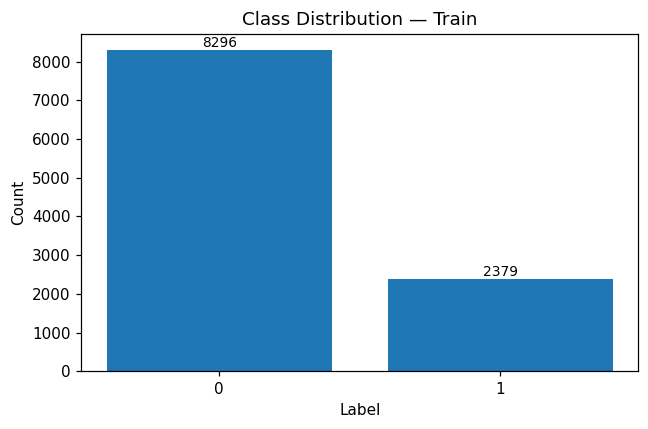

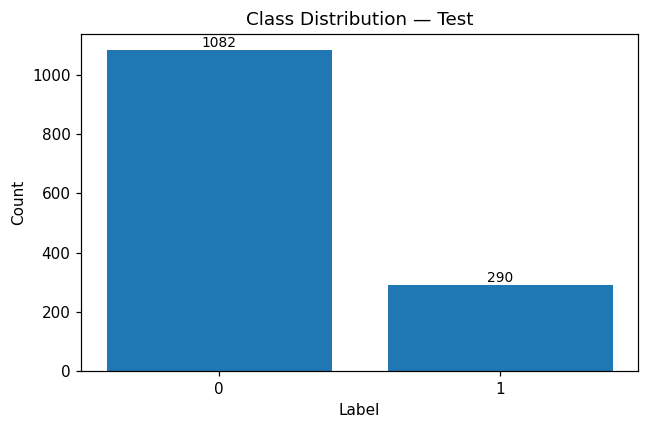

[Train] Missing: 0/10675 — saved to ./ConvNeXt_V2_(Sampler on)output\eda\missing_train.txt
[Test] Missing: 0/1372 — saved to ./ConvNeXt_V2_(Sampler on)output\eda\missing_test.txt


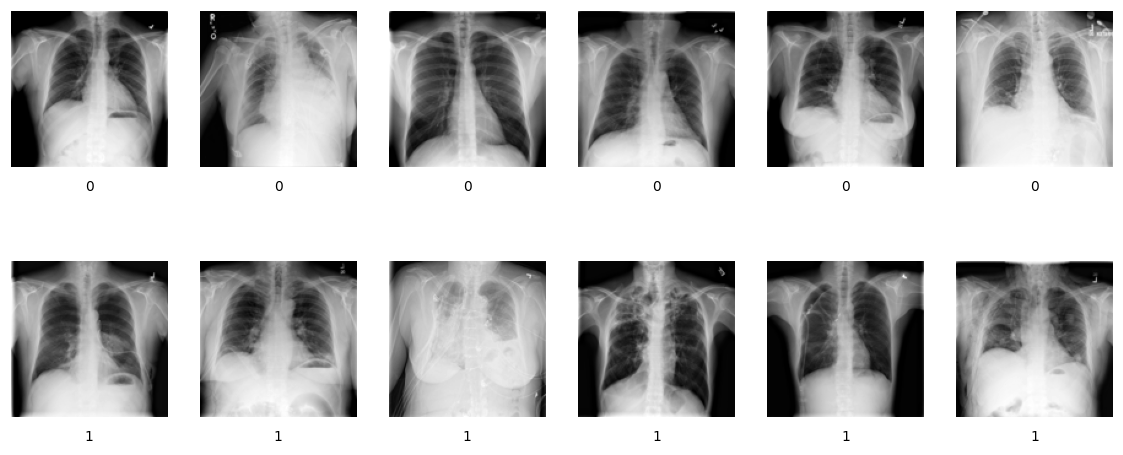

In [6]:
from pathlib import Path

eda_class_distribution(train_df, "has_pneumo", os.path.join(EDA_DIR, "class_dist_train.png"), "Train")
eda_class_distribution(test_df,  "has_pneumo", os.path.join(EDA_DIR, "class_dist_test.png"),  "Test")

eda_missing_files(train_df, os.path.join(EDA_DIR, "missing_train.txt"), "Train")
eda_missing_files(test_df,  os.path.join(EDA_DIR, "missing_test.txt"),  "Test")

def eda_sample_grid(df, out_path, split_name, n_per_class=6, size=128):
    label_col = "has_pneumo"
    path_col = "full_path" if "full_path" in df.columns else "filepath"

    classes = sorted(df[label_col].dropna().unique().tolist())
    nrows, ncols = len(classes), n_per_class
    fig, axes = plt.subplots(nrows, ncols, figsize=(ncols*2.2, nrows*2.4))
    if nrows == 1:
        axes = np.array([axes])

    for r, c in enumerate(classes):
        sub = df[df[label_col] == c]
        sampled = sub.sample(n=min(n_per_class, len(sub)), random_state=42) if len(sub) > 0 else sub
        sampled = sampled.reset_index(drop=True)

        for i in range(ncols):
            ax = axes[r, i]
            ax.set_axis_off()

            if i < len(sampled):
                row = sampled.iloc[i]
                img_path = str(Path(row[path_col]))
                try:
                    im = Image.open(img_path).convert("L")
                    if size:
                        im = im.resize((size, size))
                    ax.imshow(im, cmap="gray")
                except Exception:
                    ax.imshow(np.zeros((size, size)), cmap="gray")

                ax.text(0.5, -0.08, str(row[label_col]),
                        transform=ax.transAxes, ha="center", va="top", fontsize=9)
            else:
                ax.imshow(np.zeros((size, size)), cmap="gray")

    plt.subplots_adjust(hspace=0.6, wspace=0.05)
    plt.show()
    Path(os.path.dirname(out_path)).mkdir(parents=True, exist_ok=True)
    fig.savefig(out_path, dpi=300, bbox_inches="tight")
    plt.close(fig)

eda_sample_grid(train_df, os.path.join(EDA_DIR, "sample_grid_train.png"), "Train", n_per_class=6, size=128)

In [7]:
# Stratified split
tr_df, val_df = train_test_split(train_df, test_size=VAL_RATIO,
                                 stratify=train_df["has_pneumo"], random_state=SEED)

# Transforms
train_tfms = transforms.Compose([
    transforms.Resize((256,256)),
    transforms.RandomResizedCrop(224, scale=(0.8,1.0)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.25]),
])
eval_tfms = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.25]),
])

# Datasets
ds_train = PandasImageDataset(tr_df, transform=train_tfms)
ds_val   = PandasImageDataset(val_df, transform=eval_tfms)
ds_test  = PandasImageDataset(test_df, transform=eval_tfms)

def make_weights_for_balancing(df: pd.DataFrame) -> np.ndarray:
    counts = df["has_pneumo"].value_counts().to_dict()
    return df["has_pneumo"].map(lambda y: 1.0 / counts[int(y)]).values.astype(np.float32)

if SAMPLER == "on":
    weights = make_weights_for_balancing(tr_df)
    sampler = WeightedRandomSampler(weights, num_samples=len(weights), replacement=True)
    shuffle = False
else:
    sampler = None; shuffle = True

# DataLoaders
dl_train = DataLoader(ds_train, batch_size=BATCH, sampler=sampler, shuffle=shuffle,
                      num_workers=0, pin_memory=True)
dl_val   = DataLoader(ds_val, batch_size=BATCH, shuffle=False, num_workers=0, pin_memory=True)
dl_test  = DataLoader(ds_test, batch_size=BATCH, shuffle=False, num_workers=0, pin_memory=True)

len(ds_train), len(ds_val), len(ds_test)

(8540, 2135, 1372)

# ConvNeXt_V2
## DropPath (Random Depth)

In [8]:
def drop_path(x, drop_prob: float = 0.0, training: bool = False):
    if drop_prob == 0.0 or not training:
        return x
    keep_prob = 1.0 - drop_prob
    # Only sample along batch dimension, broadcast others
    shape = (x.shape[0],) + (1,) * (x.ndim - 1)
    random_tensor = keep_prob + torch.rand(shape, dtype=x.dtype, device=x.device)
    random_tensor.floor_()  # binarize
    return x * random_tensor / keep_prob

class DropPath(nn.Module):
    def __init__(self, drop_prob: float = 0.0):
        super().__init__()
        self.drop_prob = drop_prob

    def forward(self, x):
        return drop_path(x, self.drop_prob, self.training)

## GRN

In [9]:
class GRN(nn.Module):
    def __init__(self, dim: int):
        super().__init__()
        self.gamma = nn.Parameter(torch.zeros(1, 1, 1, dim))
        self.beta = nn.Parameter(torch.zeros(1, 1, 1, dim))

    def forward(self, x):
        gx = torch.norm(x, p=2, dim=(1, 2), keepdim=True)                # [N,1,1,C]
        nx = gx / (gx.mean(dim=-1, keepdim=True) + 1e-6)                 # [N,1,1,C]
        return self.gamma * (x * nx) + self.beta + x                     # [N,H,W,C]

## LayerNorm2d

In [10]:
class LayerNorm2d(nn.Module):
    def __init__(self, num_channels: int, eps: float = 1e-6):
        super().__init__()
        self.weight = nn.Parameter(torch.ones(num_channels))
        self.bias = nn.Parameter(torch.zeros(num_channels))
        self.eps = eps

    def forward(self, x):
        mean = x.mean(dim=1, keepdim=True)
        var = (x - mean).pow(2).mean(dim=1, keepdim=True)
        x = (x - mean) / torch.sqrt(var + self.eps)
        return self.weight.view(1, -1, 1, 1) * x + self.bias.view(1, -1, 1, 1)

## ConvNeXt_V2 block

In [11]:
class ConvNeXtV2Block(nn.Module):
    def __init__(
        self,
        dim: int,
        mlp_ratio: float = 4.0,
        drop_path: float = 0.0,
        layer_scale_init_value: float = 0.0,  
    ):
        super().__init__()
        # 7x7 depthwise convolution
        self.dwconv = nn.Conv2d(dim, dim, kernel_size=7, padding=3, groups=dim)

        # Do LayerNorm in channels_last format
        self.norm = nn.LayerNorm(dim, eps=1e-6)

        hidden_dim = int(dim * mlp_ratio)
        self.pwconv1 = nn.Linear(dim, hidden_dim)
        self.act = nn.GELU()
        self.grn = GRN(hidden_dim)
        self.pwconv2 = nn.Linear(hidden_dim, dim)

        # LayerScale
        if layer_scale_init_value > 0:
            self.gamma = nn.Parameter(layer_scale_init_value * torch.ones(dim))
        else:
            self.gamma = None

        self.drop_path = DropPath(drop_path) if drop_path > 0.0 else nn.Identity()

    def forward(self, x):
        shortcut = x  # [N, C, H, W]

        x = self.dwconv(x)

        # NCHW -> NHWC
        x = x.permute(0, 2, 3, 1)
        x = self.norm(x)
        x = self.pwconv1(x)
        x = self.act(x)
        x = self.grn(x)
        x = self.pwconv2(x)

        if self.gamma is not None:
            x = self.gamma.view(1, 1, 1, -1) * x

        # NHWC -> NCHW
        x = x.permute(0, 3, 1, 2)

        x = shortcut + self.drop_path(x)
        return x

## ConvNeXt_V2 tiny

In [12]:
class ConvNeXtV2Tiny(nn.Module):
    def __init__(
        self,
        in_chans: int = 3,
        num_classes: int = 1000,
        drop_path_rate: float = 0.0,
        layer_scale_init_value: float = 0.0, 
    ):
        super().__init__()

        # 4 deepths and dims for each stage
        depths = [3, 3, 9, 3]
        dims = [96, 192, 384, 768]

        self.downsample_layers = nn.ModuleList()
        self.stages = nn.ModuleList()

        # Constructing the stem: patch embedding with stride=4
        stem = nn.Sequential(
            nn.Conv2d(in_chans, dims[0], kernel_size=4, stride=4),
            LayerNorm2d(dims[0]),
        )
        self.downsample_layers.append(stem)

        # Constructing the blocks and downsampling layers for each stage
        total_blocks = sum(depths)
        dpr_values = torch.linspace(0, drop_path_rate, total_blocks).tolist()
        block_idx = 0

        for stage_idx in range(4):
            depth = depths[stage_idx]
            dim = dims[stage_idx]

            # Every stage begins with a downsampling layer (except the first)
            if stage_idx > 0:
                down = nn.Sequential(
                    LayerNorm2d(dims[stage_idx - 1]),
                    nn.Conv2d(dims[stage_idx - 1], dim, kernel_size=2, stride=2),
                )
                self.downsample_layers.append(down)

            blocks = []
            for i in range(depth):
                blocks.append(
                    ConvNeXtV2Block(
                        dim=dim,
                        mlp_ratio=4.0,
                        drop_path=dpr_values[block_idx + i],
                        layer_scale_init_value=layer_scale_init_value,
                    )
                )
            block_idx += depth

            self.stages.append(nn.Sequential(*blocks))

        # The last classification head: LN + Linear
        self.norm_head = nn.LayerNorm(dims[-1], eps=1e-6)
        self.head = (
            nn.Linear(dims[-1], num_classes) if num_classes > 0 else nn.Identity()
        )

    def forward_features(self, x):
        # Downsampling through stages
        for i in range(4):
            x = self.downsample_layers[i](x)
            x = self.stages[i](x)

        # Global average pooling and normalization
        x = x.mean(dim=[2, 3])
        x = self.norm_head(x)
        return x

    def forward(self, x):
        x = self.forward_features(x)
        x = self.head(x)  # [N, num_classes]
        return x
    
class ConvNeXtV2TinyScratch(nn.Module):
    def __init__(
        self,
        in_chans: int = 1,
        n_classes: int = 1,
        drop_path_rate: float = 0.1,
    ):
        super().__init__()
        self.backbone = ConvNeXtV2Tiny(
            in_chans=in_chans,
            num_classes=n_classes,
            drop_path_rate=drop_path_rate,
            layer_scale_init_value=0.0,  
        )

    def forward(self, x):
        logits = self.backbone(x)  # [B, 1]
        return logits.squeeze(1)   # [B]
    
model = ConvNeXtV2TinyScratch(in_chans=1, n_classes=1, drop_path_rate=0.1).to(device)

In [13]:
# pos = (np.array(tr_df["has_pneumo"])==1).sum()
# neg = (np.array(tr_df["has_pneumo"])==0).sum()
# pos_weight = torch.tensor([neg / max(pos,1)], device=device, dtype=torch.float32)

# criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
# optimizer = torch.optim.Adam(model.parameters(), lr=LR)
# scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)
# scaler = torch.cuda.amp.GradScaler(enabled=(device.type=='cuda'))

# print("pos/neg:", pos, neg, "| pos_weight:", pos_weight.item())

# Calculate class weights for Focal Loss
pos = (np.array(tr_df["has_pneumo"]) == 1).sum()
neg = (np.array(tr_df["has_pneumo"]) == 0).sum()

alpha = neg / (pos + neg + 1e-8)  

print(f"Train pos={pos}, neg={neg}, alpha={alpha:.4f}")

# Define Binary Focal Loss
class BinaryFocalLoss(nn.Module):
    def __init__(self, alpha=0.25, gamma=2.0, reduction="mean"):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, logits, targets):
        if logits.dim() > targets.dim():
            targets = targets.view_as(logits)
        targets = targets.float()

        # Probabilities for the true class
        prob = torch.sigmoid(logits)
        pt = prob * targets + (1 - prob) * (1 - targets)  

        # Weighted alpha factor
        alpha_t = self.alpha * targets + (1 - self.alpha) * (1 - targets)

        # Focal weight
        focal_weight = alpha_t * (1 - pt).pow(self.gamma)

        # Basic BCE with logits
        bce = F.binary_cross_entropy_with_logits(
            logits, targets, reduction="none"
        )
        loss = focal_weight * bce

        if self.reduction == "mean":
            return loss.mean()
        elif self.reduction == "sum":
            return loss.sum()
        return loss

# Create criterion, optimizer, scheduler, scaler
criterion = BinaryFocalLoss(alpha=alpha, gamma=2.0)
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)
scaler = torch.cuda.amp.GradScaler(enabled=(device.type=='cuda'))


Train pos=1903, neg=6637, alpha=0.7772


C:\Users\Steven\AppData\Local\Temp\ipykernel_69432\123977394.py:59: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(device.type=='cuda'))


In [14]:
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, average_precision_score, confusion_matrix,
    roc_curve, precision_recall_curve
)

@torch.no_grad()
def evaluate(model, loader, device):
    model.eval()
    ys, preds, scores = [], [], []
    for xb, yb in loader:
        xb = xb.to(device, non_blocking=True)
        yb = yb.to(device, non_blocking=True)
        logits = model(xb)             # [B]
        probs = torch.sigmoid(logits)  # [B]
        pred = (probs >= 0.5).long()

        ys.extend(yb.cpu().numpy().tolist())
        preds.extend(pred.cpu().numpy().tolist())
        scores.extend(probs.cpu().numpy().tolist())

    y_true = np.array(ys)
    y_pred = np.array(preds)
    y_score = np.array(scores)

    acc  = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec  = recall_score(y_true, y_pred, zero_division=0)
    f1   = f1_score(y_true, y_pred, zero_division=0)

    # Specificity = TN / (TN + FP)
    try:
        cm = confusion_matrix(y_true, y_pred)
        if cm.shape == (2, 2):
            tn, fp, fn, tp = cm.ravel()
            spec = tn / (tn + fp + 1e-8)
        else:
            spec = float("nan")
    except Exception:
        spec = float("nan")

    # ROC-AUC & PR-AUC
    try:
        roc = roc_auc_score(y_true, y_score)
    except Exception:
        roc = float("nan")

    try:
        pr  = average_precision_score(y_true, y_score)
    except Exception:
        pr  = float("nan")

    metrics = {
        "acc": acc,
        "prec": prec,
        "rec": rec,
        "f1": f1,
        "spec": spec,
        "roc_auc": roc,
        "pr_auc": pr,
    }
    return metrics, y_true, y_pred, y_score

def plot_confusion_matrix(y_true, y_pred, out_path, title="Confusion Matrix"):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5,4))
    plt.imshow(cm, interpolation="nearest")
    plt.title(title)
    plt.colorbar()
    ticks = np.arange(2)
    plt.xticks(ticks, ['0','1']); plt.yticks(ticks, ['0','1'])
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], 'd'), ha="center", va="center")
    plt.ylabel("Actual"); plt.xlabel("Predicted")
    plt.tight_layout()
    plt.savefig(out_path, dpi=300)
    plt.show()

def plot_roc_pr(y_true, y_score, out_dir, prefix="eval",
                roc_auc=None, pr_auc=None):
    os.makedirs(out_dir, exist_ok=True)

    # ROC
    try:
        fpr, tpr, _ = roc_curve(y_true, y_score)
        plt.figure(figsize=(5,4))
        plt.plot(fpr, tpr, label=f"ROC (AUC={roc_auc:.3f})" if roc_auc is not None else "ROC")
        plt.plot([0,1],[0,1], linestyle="--", label="Random")
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title(f"ROC Curve ({prefix})")
        plt.legend()
        plt.tight_layout()
        plt.savefig(os.path.join(out_dir, f"{prefix}_roc.png"), dpi=300)
        plt.show()
    except Exception as e:
        print("ROC failed:", e)

    # PR
    try:
        prec, rec, _ = precision_recall_curve(y_true, y_score)
        plt.figure(figsize=(5,4))
        plt.plot(rec, prec, label=f"PR (AP={pr_auc:.3f})" if pr_auc is not None else "PR")
        plt.xlabel("Recall")
        plt.ylabel("Precision")
        plt.title(f"Precision–Recall Curve ({prefix})")
        plt.legend()
        plt.tight_layout()
        plt.savefig(os.path.join(out_dir, f"{prefix}_pr.png"), dpi=300)
        plt.show()
    except Exception as e:
        print("PR failed:", e)

def plot_learning_curves(history, best_epoch, out_dir, prefix="convnextv2_tiny"):
    os.makedirs(out_dir, exist_ok=True)

    epochs = np.arange(1, best_epoch + 1)

    train_loss = history["train_loss"][:best_epoch]
    val_loss   = history["val_loss"][:best_epoch]
    val_f1     = np.array(history["val_f1"][:best_epoch]) * 100.0

    # --- Loss Learning Curve ---
    plt.figure(figsize=(6,4))
    plt.plot(epochs, train_loss, label="Train Loss")
    plt.plot(epochs, val_loss,   label="Val Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(f"Learning Curve (Loss, Best Epoch = {best_epoch})")
    plt.legend()
    plt.tight_layout()
    plt.savefig(os.path.join(out_dir, f"{prefix}_learning_loss_best.png"), dpi=300)
    plt.show()

    # --- F1 Learning Curve ---
    plt.figure(figsize=(6,4))
    plt.plot(epochs, val_f1, marker="o", label="Val F1 (macro)")
    plt.xlabel("Epoch")
    plt.ylabel("Val F1 (%)")
    plt.title(f"Learning Curve (Val F1, Best Epoch = {best_epoch})")
    plt.legend()
    plt.tight_layout()
    plt.savefig(os.path.join(out_dir, f"{prefix}_learning_f1_best.png"), dpi=300)
    plt.show()

In [15]:
from tqdm.auto import tqdm

# Early Stopping parameters
MONITOR    = "pr_auc" 
MODE       = "max"
PATIENCE   = 8
MIN_EPOCHS = 10
DELTA      = 1e-4

best_score   = -float('inf')
best_epoch   = 0
epochs_bad   = 0
BEST_STATE   = None

history = {
    "train_loss": [],
    "val_loss":   [],
    "val_acc":    [],
    "val_prec":   [],
    "val_rec":    [],
    "val_f1":     [],
    "val_spec":   [],
    "val_roc":    [],
    "val_pr":     [],
}

print("[Info] Start training...")
for epoch in range(1, EPOCHS+1):
    model.train()
    running, nb = 0.0, 0
    bar = tqdm(total=len(dl_train), leave=True, desc=f"Epoch {epoch}/{EPOCHS}")

    for xb, yb in dl_train:
        xb = xb.to(device, non_blocking=True)
        yb = yb.to(device, non_blocking=True).float()

        optimizer.zero_grad(set_to_none=True)
        
        # Mixed precision training
        with torch.amp.autocast('cuda', enabled=(device.type=='cuda')):
            logits = model(xb)             # [B]
            loss = criterion(logits, yb)   # BCEWithLogitsLoss

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        

        running += loss.item()
        nb += 1
      
        try:
            curr_lr = scheduler.get_last_lr()[0]
        except Exception:
            curr_lr = optimizer.param_groups[0]["lr"]
        bar.set_postfix(loss=f"{running/max(nb,1):.4f}", lr=f"{curr_lr:.2e}")
        bar.update(1)
    scheduler.step() 
    bar.close()

    # Calculate train and val loss for the epoch
    train_loss_epoch = running / max(nb, 1)
    
    model.eval()
    val_running, val_nb = 0.0, 0
    with torch.no_grad():
        for xb, yb in dl_val:
            xb = xb.to(device, non_blocking=True)
            yb = yb.to(device, non_blocking=True).float()
            logits = model(xb)
            loss_val = criterion(logits, yb)
            val_running += loss_val.item()
            val_nb += 1
    val_loss_epoch = val_running / max(val_nb, 1)

    metrics, yv, pv, sv = evaluate(model, dl_val, device)
    score = float(metrics.get(MONITOR, float('nan')))
    improved = score > (best_score + DELTA)

    history["train_loss"].append(train_loss_epoch)
    history["val_loss"].append(val_loss_epoch)
    history["val_acc"].append(metrics["acc"])
    history["val_prec"].append(metrics["prec"])
    history["val_rec"].append(metrics["rec"])
    history["val_f1"].append(metrics["f1"])
    history["val_spec"].append(metrics["spec"])
    history["val_roc"].append(metrics["roc_auc"])
    history["val_pr"].append(metrics["pr_auc"])

    if improved:
        best_score = score
        best_epoch = epoch
        BEST_STATE = {k: v.cpu() for k, v in model.state_dict().items()}
        epochs_bad = 0
    else:
        epochs_bad += 1

    tqdm.write(
        f"Epoch {epoch:02d}/{EPOCHS} "
        f"train_loss={train_loss_epoch:.4f} val_loss={val_loss_epoch:.4f} "
        f"val_acc={metrics['acc']:.4f} val_prec={metrics['prec']:.4f} "
        f"val_rec={metrics['rec']:.4f} val_f1={metrics['f1']:.4f} "
        f"val_spec={metrics['spec']:.4f} "
        f"val_roc={metrics['roc_auc']:.4f} val_pr={metrics['pr_auc']:.4f} "
        f"| val_{MONITOR}={score:.4f} best_{MONITOR}={best_score:.4f} (epoch {best_epoch})"
    )

    if epoch >= MIN_EPOCHS and epochs_bad >= PATIENCE:
        tqdm.write(f"[EarlyStop] Stop at epoch {epoch}. Best {MONITOR}={best_score:.4f} @ epoch {best_epoch}.")
        break

# Save best model
if BEST_STATE is not None:
    torch.save(BEST_STATE, os.path.join(OUT_DIR, "best_cnn.pt"))
    model.load_state_dict(BEST_STATE)

[Info] Start training...


Epoch 1/100:   0%|          | 0/267 [00:00<?, ?it/s]

Epoch 01/100 train_loss=0.0986 val_loss=0.0908 val_acc=0.2230 val_prec=0.2230 val_rec=1.0000 val_f1=0.3646 val_spec=0.0000 val_roc=0.6043 val_pr=0.2991 | val_pr_auc=0.2991 best_pr_auc=0.2991 (epoch 1)


Epoch 2/100:   0%|          | 0/267 [00:00<?, ?it/s]

Epoch 02/100 train_loss=0.0688 val_loss=0.0848 val_acc=0.2230 val_prec=0.2230 val_rec=1.0000 val_f1=0.3646 val_spec=0.0000 val_roc=0.6255 val_pr=0.3029 | val_pr_auc=0.3029 best_pr_auc=0.3029 (epoch 2)


Epoch 3/100:   0%|          | 0/267 [00:00<?, ?it/s]

Epoch 03/100 train_loss=0.0691 val_loss=0.0735 val_acc=0.2230 val_prec=0.2230 val_rec=1.0000 val_f1=0.3646 val_spec=0.0000 val_roc=0.6384 val_pr=0.3041 | val_pr_auc=0.3041 best_pr_auc=0.3041 (epoch 3)


Epoch 4/100:   0%|          | 0/267 [00:00<?, ?it/s]

Epoch 04/100 train_loss=0.0680 val_loss=0.0859 val_acc=0.2230 val_prec=0.2230 val_rec=1.0000 val_f1=0.3646 val_spec=0.0000 val_roc=0.6423 val_pr=0.3089 | val_pr_auc=0.3089 best_pr_auc=0.3089 (epoch 4)


Epoch 5/100:   0%|          | 0/267 [00:00<?, ?it/s]

Epoch 05/100 train_loss=0.0669 val_loss=0.0659 val_acc=0.2604 val_prec=0.2306 val_rec=0.9916 val_f1=0.3742 val_spec=0.0506 val_roc=0.6477 val_pr=0.3280 | val_pr_auc=0.3280 best_pr_auc=0.3280 (epoch 5)


Epoch 6/100:   0%|          | 0/267 [00:00<?, ?it/s]

Epoch 06/100 train_loss=0.0668 val_loss=0.0659 val_acc=0.2492 val_prec=0.2282 val_rec=0.9937 val_f1=0.3711 val_spec=0.0356 val_roc=0.6544 val_pr=0.3251 | val_pr_auc=0.3251 best_pr_auc=0.3280 (epoch 5)


Epoch 7/100:   0%|          | 0/267 [00:00<?, ?it/s]

Epoch 07/100 train_loss=0.0651 val_loss=0.0811 val_acc=0.2496 val_prec=0.2283 val_rec=0.9937 val_f1=0.3713 val_spec=0.0362 val_roc=0.6685 val_pr=0.3332 | val_pr_auc=0.3332 best_pr_auc=0.3332 (epoch 7)


Epoch 8/100:   0%|          | 0/267 [00:00<?, ?it/s]

Epoch 08/100 train_loss=0.0646 val_loss=0.0652 val_acc=0.3742 val_prec=0.2551 val_rec=0.9412 val_f1=0.4014 val_spec=0.2116 val_roc=0.6985 val_pr=0.3690 | val_pr_auc=0.3690 best_pr_auc=0.3690 (epoch 8)


Epoch 9/100:   0%|          | 0/267 [00:00<?, ?it/s]

Epoch 09/100 train_loss=0.0630 val_loss=0.0674 val_acc=0.2670 val_prec=0.2324 val_rec=0.9937 val_f1=0.3767 val_spec=0.0585 val_roc=0.7158 val_pr=0.4011 | val_pr_auc=0.4011 best_pr_auc=0.4011 (epoch 9)


Epoch 10/100:   0%|          | 0/267 [00:00<?, ?it/s]

Epoch 10/100 train_loss=0.0622 val_loss=0.0618 val_acc=0.3958 val_prec=0.2639 val_rec=0.9559 val_f1=0.4136 val_spec=0.2351 val_roc=0.7201 val_pr=0.3826 | val_pr_auc=0.3826 best_pr_auc=0.4011 (epoch 9)


Epoch 11/100:   0%|          | 0/267 [00:00<?, ?it/s]

Epoch 11/100 train_loss=0.0601 val_loss=0.0678 val_acc=0.3888 val_prec=0.2605 val_rec=0.9475 val_f1=0.4087 val_spec=0.2285 val_roc=0.7196 val_pr=0.4186 | val_pr_auc=0.4186 best_pr_auc=0.4186 (epoch 11)


Epoch 12/100:   0%|          | 0/267 [00:00<?, ?it/s]

Epoch 12/100 train_loss=0.0577 val_loss=0.0698 val_acc=0.4351 val_prec=0.2785 val_rec=0.9643 val_f1=0.4322 val_spec=0.2833 val_roc=0.7739 val_pr=0.4778 | val_pr_auc=0.4778 best_pr_auc=0.4778 (epoch 12)


Epoch 13/100:   0%|          | 0/267 [00:00<?, ?it/s]

Epoch 13/100 train_loss=0.0567 val_loss=0.0525 val_acc=0.6009 val_prec=0.3459 val_rec=0.8866 val_f1=0.4976 val_spec=0.5190 val_roc=0.7922 val_pr=0.5098 | val_pr_auc=0.5098 best_pr_auc=0.5098 (epoch 13)


Epoch 14/100:   0%|          | 0/267 [00:00<?, ?it/s]

Epoch 14/100 train_loss=0.0555 val_loss=0.0556 val_acc=0.5822 val_prec=0.3367 val_rec=0.9013 val_f1=0.4903 val_spec=0.4907 val_roc=0.8038 val_pr=0.5151 | val_pr_auc=0.5151 best_pr_auc=0.5151 (epoch 14)


Epoch 15/100:   0%|          | 0/267 [00:00<?, ?it/s]

Epoch 15/100 train_loss=0.0544 val_loss=0.0676 val_acc=0.3883 val_prec=0.2637 val_rec=0.9727 val_f1=0.4149 val_spec=0.2206 val_roc=0.7709 val_pr=0.4754 | val_pr_auc=0.4754 best_pr_auc=0.5151 (epoch 14)


Epoch 16/100:   0%|          | 0/267 [00:00<?, ?it/s]

Epoch 16/100 train_loss=0.0526 val_loss=0.0568 val_acc=0.5742 val_prec=0.3349 val_rec=0.9223 val_f1=0.4913 val_spec=0.4744 val_roc=0.8144 val_pr=0.5295 | val_pr_auc=0.5295 best_pr_auc=0.5295 (epoch 16)


Epoch 17/100:   0%|          | 0/267 [00:00<?, ?it/s]

Epoch 17/100 train_loss=0.0513 val_loss=0.0557 val_acc=0.5602 val_prec=0.3289 val_rec=0.9349 val_f1=0.4866 val_spec=0.4527 val_roc=0.8093 val_pr=0.5240 | val_pr_auc=0.5240 best_pr_auc=0.5295 (epoch 16)


Epoch 18/100:   0%|          | 0/267 [00:00<?, ?it/s]

Epoch 18/100 train_loss=0.0487 val_loss=0.0556 val_acc=0.5696 val_prec=0.3323 val_rec=0.9223 val_f1=0.4886 val_spec=0.4684 val_roc=0.8150 val_pr=0.5386 | val_pr_auc=0.5386 best_pr_auc=0.5386 (epoch 18)


Epoch 19/100:   0%|          | 0/267 [00:00<?, ?it/s]

Epoch 19/100 train_loss=0.0488 val_loss=0.0555 val_acc=0.6037 val_prec=0.3498 val_rec=0.9055 val_f1=0.5047 val_spec=0.5172 val_roc=0.8143 val_pr=0.5513 | val_pr_auc=0.5513 best_pr_auc=0.5513 (epoch 19)


Epoch 20/100:   0%|          | 0/267 [00:00<?, ?it/s]

Epoch 20/100 train_loss=0.0480 val_loss=0.0578 val_acc=0.5400 val_prec=0.3201 val_rec=0.9454 val_f1=0.4782 val_spec=0.4237 val_roc=0.8249 val_pr=0.5523 | val_pr_auc=0.5523 best_pr_auc=0.5523 (epoch 20)


Epoch 21/100:   0%|          | 0/267 [00:00<?, ?it/s]

Epoch 21/100 train_loss=0.0475 val_loss=0.0495 val_acc=0.6960 val_prec=0.4105 val_rec=0.8340 val_f1=0.5502 val_spec=0.6564 val_roc=0.8240 val_pr=0.5670 | val_pr_auc=0.5670 best_pr_auc=0.5670 (epoch 21)


Epoch 22/100:   0%|          | 0/267 [00:00<?, ?it/s]

Epoch 22/100 train_loss=0.0463 val_loss=0.0621 val_acc=0.5738 val_prec=0.3326 val_rec=0.9055 val_f1=0.4865 val_spec=0.4786 val_roc=0.8158 val_pr=0.5447 | val_pr_auc=0.5447 best_pr_auc=0.5670 (epoch 21)


Epoch 23/100:   0%|          | 0/267 [00:00<?, ?it/s]

Epoch 23/100 train_loss=0.0441 val_loss=0.0502 val_acc=0.6754 val_prec=0.3946 val_rec=0.8529 val_f1=0.5395 val_spec=0.6245 val_roc=0.8269 val_pr=0.5638 | val_pr_auc=0.5638 best_pr_auc=0.5670 (epoch 21)


Epoch 24/100:   0%|          | 0/267 [00:00<?, ?it/s]

Epoch 24/100 train_loss=0.0451 val_loss=0.0504 val_acc=0.6389 val_prec=0.3723 val_rec=0.9034 val_f1=0.5273 val_spec=0.5630 val_roc=0.8362 val_pr=0.5879 | val_pr_auc=0.5879 best_pr_auc=0.5879 (epoch 24)


Epoch 25/100:   0%|          | 0/267 [00:00<?, ?it/s]

Epoch 25/100 train_loss=0.0427 val_loss=0.0569 val_acc=0.6173 val_prec=0.3585 val_rec=0.9076 val_f1=0.5140 val_spec=0.5341 val_roc=0.8257 val_pr=0.5728 | val_pr_auc=0.5728 best_pr_auc=0.5879 (epoch 24)


Epoch 26/100:   0%|          | 0/267 [00:00<?, ?it/s]

Epoch 26/100 train_loss=0.0409 val_loss=0.0546 val_acc=0.6913 val_prec=0.4082 val_rec=0.8550 val_f1=0.5526 val_spec=0.6444 val_roc=0.8335 val_pr=0.5949 | val_pr_auc=0.5949 best_pr_auc=0.5949 (epoch 26)


Epoch 27/100:   0%|          | 0/267 [00:00<?, ?it/s]

Epoch 27/100 train_loss=0.0404 val_loss=0.0528 val_acc=0.6993 val_prec=0.4141 val_rec=0.8403 val_f1=0.5548 val_spec=0.6588 val_roc=0.8325 val_pr=0.5797 | val_pr_auc=0.5797 best_pr_auc=0.5949 (epoch 26)


Epoch 28/100:   0%|          | 0/267 [00:00<?, ?it/s]

Epoch 28/100 train_loss=0.0396 val_loss=0.0526 val_acc=0.6904 val_prec=0.4092 val_rec=0.8761 val_f1=0.5579 val_spec=0.6371 val_roc=0.8317 val_pr=0.5860 | val_pr_auc=0.5860 best_pr_auc=0.5949 (epoch 26)


Epoch 29/100:   0%|          | 0/267 [00:00<?, ?it/s]

Epoch 29/100 train_loss=0.0379 val_loss=0.0653 val_acc=0.6150 val_prec=0.3561 val_rec=0.8992 val_f1=0.5101 val_spec=0.5335 val_roc=0.8267 val_pr=0.5813 | val_pr_auc=0.5813 best_pr_auc=0.5949 (epoch 26)


Epoch 30/100:   0%|          | 0/267 [00:00<?, ?it/s]

Epoch 30/100 train_loss=0.0372 val_loss=0.0668 val_acc=0.6225 val_prec=0.3623 val_rec=0.9118 val_f1=0.5185 val_spec=0.5395 val_roc=0.8309 val_pr=0.5726 | val_pr_auc=0.5726 best_pr_auc=0.5949 (epoch 26)


Epoch 31/100:   0%|          | 0/267 [00:00<?, ?it/s]

Epoch 31/100 train_loss=0.0359 val_loss=0.0484 val_acc=0.7288 val_prec=0.4423 val_rec=0.8298 val_f1=0.5771 val_spec=0.6998 val_roc=0.8371 val_pr=0.5968 | val_pr_auc=0.5968 best_pr_auc=0.5968 (epoch 31)


Epoch 32/100:   0%|          | 0/267 [00:00<?, ?it/s]

Epoch 32/100 train_loss=0.0348 val_loss=0.0612 val_acc=0.7087 val_prec=0.4233 val_rec=0.8466 val_f1=0.5644 val_spec=0.6691 val_roc=0.8372 val_pr=0.6025 | val_pr_auc=0.6025 best_pr_auc=0.6025 (epoch 32)


Epoch 33/100:   0%|          | 0/267 [00:00<?, ?it/s]

Epoch 33/100 train_loss=0.0325 val_loss=0.0697 val_acc=0.6778 val_prec=0.3969 val_rec=0.8571 val_f1=0.5426 val_spec=0.6263 val_roc=0.8282 val_pr=0.5676 | val_pr_auc=0.5676 best_pr_auc=0.6025 (epoch 32)


Epoch 34/100:   0%|          | 0/267 [00:00<?, ?it/s]

Epoch 34/100 train_loss=0.0325 val_loss=0.0599 val_acc=0.7494 val_prec=0.4649 val_rec=0.8214 val_f1=0.5938 val_spec=0.7288 val_roc=0.8415 val_pr=0.6054 | val_pr_auc=0.6054 best_pr_auc=0.6054 (epoch 34)


Epoch 35/100:   0%|          | 0/267 [00:00<?, ?it/s]

Epoch 35/100 train_loss=0.0319 val_loss=0.0595 val_acc=0.6740 val_prec=0.3944 val_rec=0.8634 val_f1=0.5415 val_spec=0.6197 val_roc=0.8333 val_pr=0.5894 | val_pr_auc=0.5894 best_pr_auc=0.6054 (epoch 34)


Epoch 36/100:   0%|          | 0/267 [00:00<?, ?it/s]

Epoch 36/100 train_loss=0.0300 val_loss=0.0638 val_acc=0.7283 val_prec=0.4404 val_rec=0.8067 val_f1=0.5697 val_spec=0.7058 val_roc=0.8344 val_pr=0.5987 | val_pr_auc=0.5987 best_pr_auc=0.6054 (epoch 34)


Epoch 37/100:   0%|          | 0/267 [00:00<?, ?it/s]

Epoch 37/100 train_loss=0.0298 val_loss=0.0658 val_acc=0.7616 val_prec=0.4786 val_rec=0.7752 val_f1=0.5918 val_spec=0.7577 val_roc=0.8417 val_pr=0.6106 | val_pr_auc=0.6106 best_pr_auc=0.6106 (epoch 37)


Epoch 38/100:   0%|          | 0/267 [00:00<?, ?it/s]

Epoch 38/100 train_loss=0.0282 val_loss=0.0684 val_acc=0.7625 val_prec=0.4806 val_rec=0.8067 val_f1=0.6024 val_spec=0.7498 val_roc=0.8403 val_pr=0.5946 | val_pr_auc=0.5946 best_pr_auc=0.6106 (epoch 37)


Epoch 39/100:   0%|          | 0/267 [00:00<?, ?it/s]

Epoch 39/100 train_loss=0.0269 val_loss=0.0726 val_acc=0.7616 val_prec=0.4788 val_rec=0.7815 val_f1=0.5938 val_spec=0.7559 val_roc=0.8360 val_pr=0.6047 | val_pr_auc=0.6047 best_pr_auc=0.6106 (epoch 37)


Epoch 40/100:   0%|          | 0/267 [00:00<?, ?it/s]

Epoch 40/100 train_loss=0.0274 val_loss=0.0684 val_acc=0.7677 val_prec=0.4872 val_rec=0.7983 val_f1=0.6051 val_spec=0.7589 val_roc=0.8449 val_pr=0.6091 | val_pr_auc=0.6091 best_pr_auc=0.6106 (epoch 37)


Epoch 41/100:   0%|          | 0/267 [00:00<?, ?it/s]

Epoch 41/100 train_loss=0.0243 val_loss=0.0709 val_acc=0.7340 val_prec=0.4484 val_rec=0.8403 val_f1=0.5848 val_spec=0.7034 val_roc=0.8430 val_pr=0.6112 | val_pr_auc=0.6112 best_pr_auc=0.6112 (epoch 41)


Epoch 42/100:   0%|          | 0/267 [00:00<?, ?it/s]

Epoch 42/100 train_loss=0.0239 val_loss=0.0895 val_acc=0.7639 val_prec=0.4814 val_rec=0.7605 val_f1=0.5896 val_spec=0.7649 val_roc=0.8373 val_pr=0.6034 | val_pr_auc=0.6034 best_pr_auc=0.6112 (epoch 41)


Epoch 43/100:   0%|          | 0/267 [00:00<?, ?it/s]

Epoch 43/100 train_loss=0.0230 val_loss=0.0893 val_acc=0.7560 val_prec=0.4714 val_rec=0.7794 val_f1=0.5875 val_spec=0.7492 val_roc=0.8388 val_pr=0.6206 | val_pr_auc=0.6206 best_pr_auc=0.6206 (epoch 43)


Epoch 44/100:   0%|          | 0/267 [00:00<?, ?it/s]

Epoch 44/100 train_loss=0.0229 val_loss=0.0853 val_acc=0.7888 val_prec=0.5180 val_rec=0.7542 val_f1=0.6142 val_spec=0.7987 val_roc=0.8476 val_pr=0.6331 | val_pr_auc=0.6331 best_pr_auc=0.6331 (epoch 44)


Epoch 45/100:   0%|          | 0/267 [00:00<?, ?it/s]

Epoch 45/100 train_loss=0.0208 val_loss=0.0852 val_acc=0.7742 val_prec=0.4959 val_rec=0.7647 val_f1=0.6017 val_spec=0.7770 val_roc=0.8391 val_pr=0.6187 | val_pr_auc=0.6187 best_pr_auc=0.6331 (epoch 44)


Epoch 46/100:   0%|          | 0/267 [00:00<?, ?it/s]

Epoch 46/100 train_loss=0.0207 val_loss=0.1040 val_acc=0.7930 val_prec=0.5249 val_rec=0.7542 val_f1=0.6190 val_spec=0.8041 val_roc=0.8395 val_pr=0.5902 | val_pr_auc=0.5902 best_pr_auc=0.6331 (epoch 44)


Epoch 47/100:   0%|          | 0/267 [00:00<?, ?it/s]

Epoch 47/100 train_loss=0.0193 val_loss=0.0887 val_acc=0.7583 val_prec=0.4752 val_rec=0.8067 val_f1=0.5981 val_spec=0.7444 val_roc=0.8378 val_pr=0.6106 | val_pr_auc=0.6106 best_pr_auc=0.6331 (epoch 44)


Epoch 48/100:   0%|          | 0/267 [00:00<?, ?it/s]

Epoch 48/100 train_loss=0.0183 val_loss=0.0840 val_acc=0.7827 val_prec=0.5084 val_rec=0.7647 val_f1=0.6107 val_spec=0.7878 val_roc=0.8382 val_pr=0.5964 | val_pr_auc=0.5964 best_pr_auc=0.6331 (epoch 44)


Epoch 49/100:   0%|          | 0/267 [00:00<?, ?it/s]

Epoch 49/100 train_loss=0.0158 val_loss=0.0955 val_acc=0.7897 val_prec=0.5199 val_rec=0.7416 val_f1=0.6113 val_spec=0.8035 val_roc=0.8347 val_pr=0.5899 | val_pr_auc=0.5899 best_pr_auc=0.6331 (epoch 44)


Epoch 50/100:   0%|          | 0/267 [00:00<?, ?it/s]

Epoch 50/100 train_loss=0.0164 val_loss=0.1026 val_acc=0.8028 val_prec=0.5446 val_rec=0.7059 val_f1=0.6148 val_spec=0.8306 val_roc=0.8451 val_pr=0.6121 | val_pr_auc=0.6121 best_pr_auc=0.6331 (epoch 44)


Epoch 51/100:   0%|          | 0/267 [00:00<?, ?it/s]

Epoch 51/100 train_loss=0.0161 val_loss=0.0962 val_acc=0.7920 val_prec=0.5246 val_rec=0.7164 val_f1=0.6057 val_spec=0.8137 val_roc=0.8447 val_pr=0.6167 | val_pr_auc=0.6167 best_pr_auc=0.6331 (epoch 44)


Epoch 52/100:   0%|          | 0/267 [00:00<?, ?it/s]

Epoch 52/100 train_loss=0.0151 val_loss=0.0869 val_acc=0.7649 val_prec=0.4828 val_rec=0.7689 val_f1=0.5932 val_spec=0.7637 val_roc=0.8331 val_pr=0.5968 | val_pr_auc=0.5968 best_pr_auc=0.6331 (epoch 44)
[EarlyStop] Stop at epoch 52. Best pr_auc=0.6331 @ epoch 44.



[Best model @ Val]
Accuracy (%)        : 78.876
Precision (%)       : 51.804
Recall (%)          : 75.42
F1-Score (%)        : 61.42
Specificity (%)     : 79.867
ROC-AUC (%)         : 84.759
Precision-recall (%): 63.313

[Best model @ Test]
Accuracy (%)        : 78.717
Precision (%)       : 49.776
Recall (%)          : 76.552
F1-Score (%)        : 60.326
Specificity (%)     : 79.298
ROC-AUC (%)         : 85.519
Precision-recall (%): 58.712


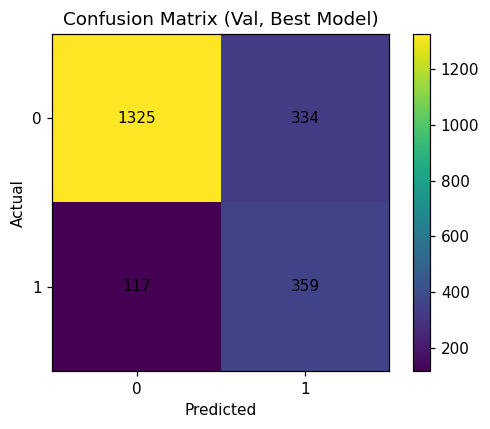

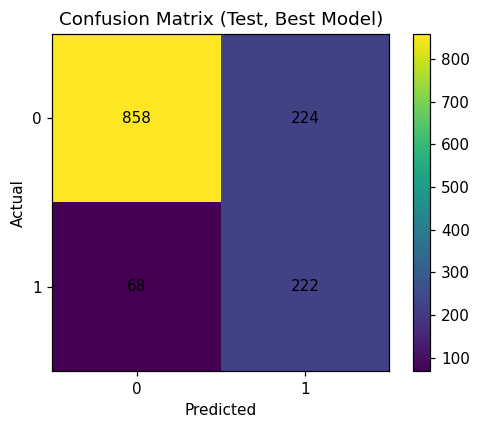

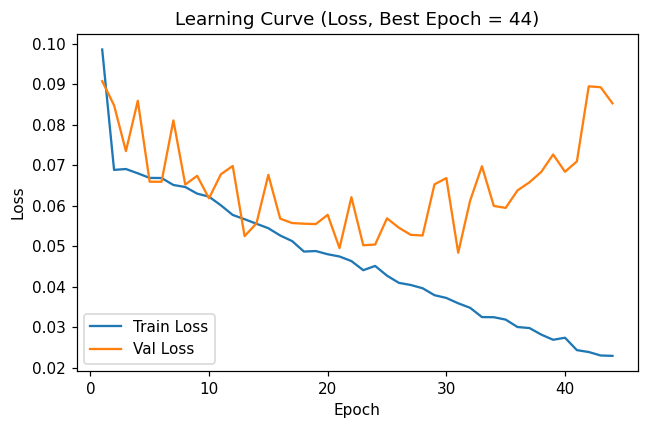

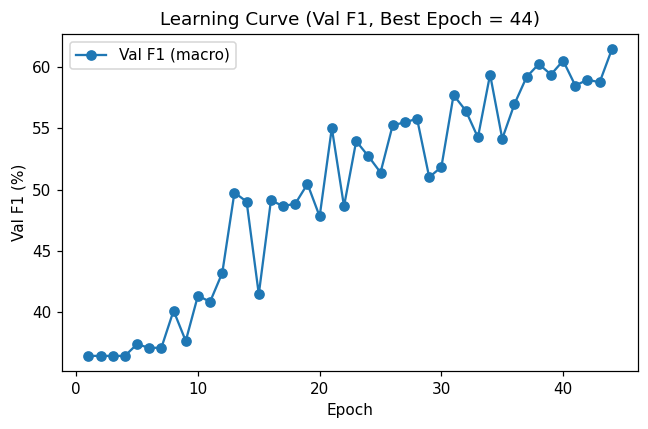

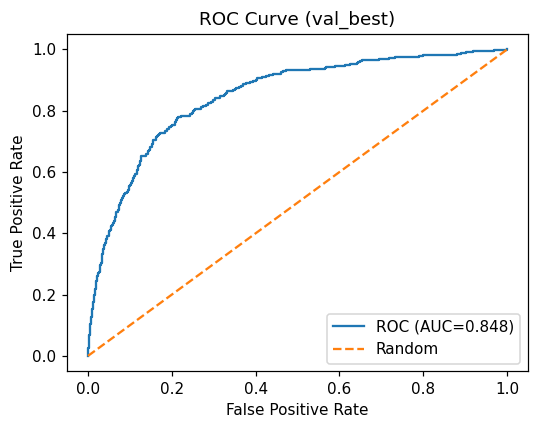

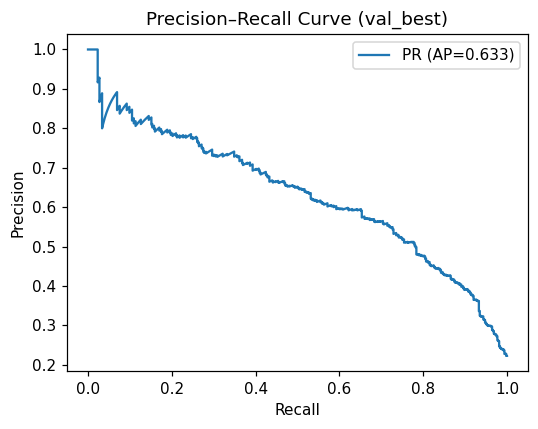

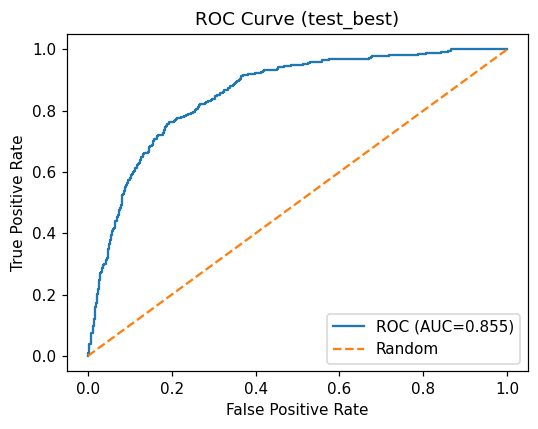

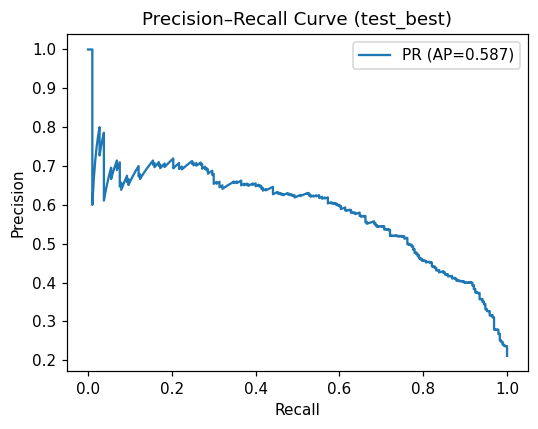

In [16]:
val_metrics_best, yv_best, pv_best, sv_best = evaluate(model, dl_val, device)
test_metrics_best, yt_best, pt_best, st_best = evaluate(model, dl_test, device)

val_pct = {k: round(v * 100, 3) for k, v in val_metrics_best.items()}
test_pct = {k: round(v * 100, 3) for k, v in test_metrics_best.items()}

print("\n[Best model @ Val]")
print("Accuracy (%)        :", val_pct["acc"])
print("Precision (%)       :", val_pct["prec"])
print("Recall (%)          :", val_pct["rec"])
print("F1-Score (%)        :", val_pct["f1"])
print("Specificity (%)     :", val_pct["spec"])
print("ROC-AUC (%)         :", val_pct["roc_auc"])
print("Precision-recall (%):", val_pct["pr_auc"])

print("\n[Best model @ Test]")
print("Accuracy (%)        :", test_pct["acc"])
print("Precision (%)       :", test_pct["prec"])
print("Recall (%)          :", test_pct["rec"])
print("F1-Score (%)        :", test_pct["f1"])
print("Specificity (%)     :", test_pct["spec"])
print("ROC-AUC (%)         :", test_pct["roc_auc"])
print("Precision-recall (%):", test_pct["pr_auc"])

plot_confusion_matrix(
    yv_best, pv_best,
    out_path=os.path.join(OUT_DIR, "confmat_val_best.png"),
    title="Confusion Matrix (Val, Best Model)"
)

plot_confusion_matrix(
    yt_best, pt_best,
    out_path=os.path.join(OUT_DIR, "confmat_test_best.png"),
    title="Confusion Matrix (Test, Best Model)"
)

plot_learning_curves(
    history=history,
    best_epoch=best_epoch,
    out_dir=OUT_DIR,
    prefix="convnextv2_tiny_focal" 
)

plot_roc_pr(
    y_true=yv_best,
    y_score=sv_best,
    out_dir=OUT_DIR,
    prefix="val_best",
    roc_auc=val_metrics_best["roc_auc"],
    pr_auc=val_metrics_best["pr_auc"]
)

plot_roc_pr(
    y_true=yt_best,
    y_score=st_best,
    out_dir=OUT_DIR,
    prefix="test_best",
    roc_auc=test_metrics_best["roc_auc"],
    pr_auc=test_metrics_best["pr_auc"]
)

In [20]:
import numpy as np
import pandas as pd
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, roc_auc_score, average_precision_score
)

def sweep_thresholds(y_true, y_score, thresholds=None, sort_by="f1", verbose=True):
    y_true = np.asarray(y_true).astype(int).ravel()
    y_score = np.asarray(y_score).ravel()

    if thresholds is None:
        thresholds = np.linspace(0.05, 0.95, 19)

    results = []
    for t in thresholds:
        y_pred = (y_score >= t).astype(int)

        acc  = accuracy_score(y_true, y_pred)
        prec = precision_score(y_true, y_pred, zero_division=0)
        rec  = recall_score(y_true, y_pred, zero_division=0)
        f1   = f1_score(y_true, y_pred, zero_division=0)

        cm = confusion_matrix(y_true, y_pred)
        if cm.shape == (2, 2):
            tn, fp, fn, tp = cm.ravel()
            spec = tn / (tn + fp + 1e-8)
        else:
            spec = float("nan")

        results.append({
            "threshold": t,
            "acc": acc,
            "prec": prec,
            "rec": rec,
            "f1": f1,
            "spec": spec,
        })

    df_thr = pd.DataFrame(results)
    df_thr_sorted = df_thr.sort_values(sort_by, ascending=False).reset_index(drop=True)

    if verbose:
        print(f"\n=== Top 10 thresholds on val (sorted by {sort_by}) ===")
        tmp = df_thr_sorted.copy()
        for col in ["acc", "prec", "rec", "f1", "spec"]:
            tmp[col] = tmp[col] * 100.0
        print(tmp.head(10).to_string(index=False, 
                                     formatters={"threshold": "{:.3f}".format,
                                                 "acc": "{:.3f}".format,
                                                 "prec": "{:.3f}".format,
                                                 "rec": "{:.3f}".format,
                                                 "f1": "{:.3f}".format,
                                                 "spec": "{:.3f}".format}))

        best_row = df_thr_sorted.iloc[0]
        print("\nBest threshold on validation set (by {}):".format(sort_by))
        print(
            f"t = {best_row['threshold']:.3f}, "
            f"Acc={best_row['acc']*100:.3f}%, "
            f"Prec={best_row['prec']*100:.3f}%, "
            f"Rec={best_row['rec']*100:.3f}%, "
            f"F1={best_row['f1']*100:.3f}%, "
            f"Spec={best_row['spec']*100:.3f}%"
        )

    return df_thr_sorted

df_thr_val = sweep_thresholds(yv_best, sv_best, sort_by="f1", verbose=True)

best_t = df_thr_val.iloc[0]["threshold"]
print(f"\n>>> The best threshold on validation set: best_t = {best_t:.3f}")

yt = np.asarray(yt_best).astype(int).ravel()
st = np.asarray(st_best).ravel()

y_test_pred = (st >= best_t).astype(int)

test_acc  = accuracy_score(yt, y_test_pred)
test_prec = precision_score(yt, y_test_pred, zero_division=0)
test_rec  = recall_score(yt, y_test_pred, zero_division=0)
test_f1   = f1_score(yt, y_test_pred, zero_division=0)

cm_test = confusion_matrix(yt, y_test_pred)
if cm_test.shape == (2, 2):
    tn, fp, fn, tp = cm_test.ravel()
    test_spec = tn / (tn + fp + 1e-8)
else:
    test_spec = float("nan")

test_roc = roc_auc_score(yt, st)
test_pr  = average_precision_score(yt, st)

print(f"\n[Best threshold model @ Test (t={best_t:.3f})]")
print(f"Accuracy (%)        : {test_acc*100:.3f}")
print(f"Precision (%)       : {test_prec*100:.3f}")
print(f"Recall (%)          : {test_rec*100:.3f}")
print(f"F1-Score (%)        : {test_f1*100:.3f}")
print(f"Specificity (%)     : {test_spec*100:.3f}")
print(f"ROC-AUC (%)         : {test_roc*100:.3f}")
print(f"Precision-recall (%): {test_pr*100:.3f}")



=== Top 10 thresholds on val (sorted by f1) ===
threshold    acc   prec    rec     f1   spec
    0.550 80.234 54.219 72.899 62.186 82.339
    0.600 81.171 56.336 69.118 62.075 84.629
    0.650 82.155 59.048 65.126 61.938 87.040
    0.500 78.876 51.804 75.420 61.420 79.867
    0.450 77.892 50.270 78.151 61.184 77.818
    0.400 76.112 47.837 78.992 59.588 75.286
    0.350 74.098 45.487 81.513 58.390 71.971
    0.700 82.155 60.870 55.882 58.269 89.693
    0.300 72.412 43.825 84.244 57.656 69.017
    0.250 69.836 41.549 86.765 56.190 64.979

Best threshold on validation set (by f1):
t = 0.550, Acc=80.234%, Prec=54.219%, Rec=72.899%, F1=62.186%, Spec=82.339%

>>> The best threshold on validation set: best_t = 0.550

[Best threshold model @ Test (t=0.550)]
Accuracy (%)        : 80.029
Precision (%)       : 51.970
Recall (%)          : 72.759
F1-Score (%)        : 60.632
Specificity (%)     : 81.978
ROC-AUC (%)         : 85.519
Precision-recall (%): 58.712


In [18]:
import pandas as pd

rows = [
    {
        "Split": "Val (Best)",
        "Accuracy (%)":         val_pct["acc"],
        "Precision (%)":        val_pct["prec"],
        "Recall (%)":           val_pct["rec"],
        "F1-Score (%)":         val_pct["f1"],
        "Specificity (%)":      val_pct["spec"],
        "ROC-AUC (%)":          val_pct["roc_auc"],
        "Precision-recall (%)": val_pct["pr_auc"],
    },
    {
        "Split": "Test (Best)",
        "Accuracy (%)":         test_pct["acc"],
        "Precision (%)":        test_pct["prec"],
        "Recall (%)":           test_pct["rec"],
        "F1-Score (%)":         test_pct["f1"],
        "Specificity (%)":      test_pct["spec"],
        "ROC-AUC (%)":          test_pct["roc_auc"],
        "Precision-recall (%)": test_pct["pr_auc"],
    },
]

df_best = pd.DataFrame(rows)
print(df_best)
df_best.to_csv(os.path.join(OUT_DIR, "best_val_test_metrics_convnextv2.csv"), index=False)


         Split  Accuracy (%)  Precision (%)  Recall (%)  F1-Score (%)  \
0   Val (Best)        78.876         51.804      75.420        61.420   
1  Test (Best)        78.717         49.776      76.552        60.326   

   Specificity (%)  ROC-AUC (%)  Precision-recall (%)  
0           79.867       84.759                63.313  
1           79.298       85.519                58.712  
